<a href="https://colab.research.google.com/github/Kaguya2906/Anomaly_Detection_Weekly_Project/blob/main/10.GBM%2CXGB%2CDeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The Boosting method fits many small models sequentially to reduce the error. It first builds a small model and calculates the residual error between the actual and the prediction. The error will be large, but no problem. In the second round, it aims at the residual error from the first round and builds a small model to reduce it. In the third round, it takes the previous residual error as the target and builds another small model to reduce it. This goes on and on until the residual error is reduced to zero. Once you aggregate all these small models, the predictability of the collective models delivers superior results. These small models are called weak learners. The superpower is not in each small model but in in the special process — it attacks the error sequentially until the error is close to zero. The best-known example is the gradient boosting technique.

In the unsupervised learning methods, I apply a Step 1–2–3 modeling procedure for (1) Model development, (2) Threshold determination, and (3) Profiles of the normal and abnormal groups. However, we can skip (2) because the target is known in XGBOD.


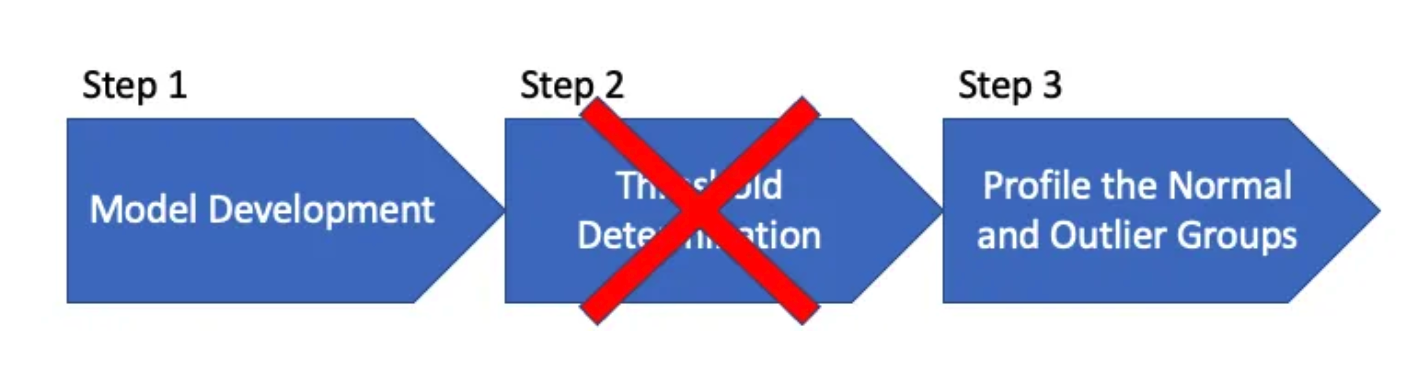




# Libraries, Dataset

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv("XYZloan_default_selected_vars.csv")
df.head()

,Unnamed: 0.1,Unnamed: 0,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,0,1,1,1,31,2,1,12,2017/7/6 10:21,ios,...,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,1,2,2,0,27,1,1,12,2017/4/6 12:51,h5,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB
2,2,3,3,0,33,1,4,12,2017/7/1 14:11,h5,...,3.0,2.0,33.0,0.0,33.0,0.0,143.0,110.0,8.0,WEB
3,3,4,4,0,34,2,4,12,2017/7/7 10:10,android,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,OPPO
4,4,5,5,0,47,2,1,12,2017/7/6 14:37,h5,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB


In [ ]:
df.shape

(80000, 89)

drop non-useful columns

In [ ]:
df= df.drop(columns=['Unnamed: 0.1',	'Unnamed: 0'])
df.head(2)

,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,1,1,31,2,1,12,2017/7/6 10:21,ios,3,3,...,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,2,0,27,1,1,12,2017/4/6 12:51,h5,5,4,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB


Check dtypes and convert those are not numericals if needed

In [ ]:
df.dtypes

id                int64
loan_default      int64
AP001             int64
AP002             int64
AP003             int64
                 ...   
CD170           float64
CD172           float64
CD173           float64
MB005           float64
MB007            object
Length: 87, dtype: object

In [ ]:
# Function to filter column names that are not int64 or float64
def filter_non_numeric_columns(df):
    non_numeric_columns = [col for col in df.columns if not pd.api.types.is_numeric_dtype(df[col])]
    return non_numeric_columns

filtered_columns = filter_non_numeric_columns(df)

print(filtered_columns)

['AP005', 'AP006', 'MB007']


AP005: split datetime into year and month

In [ ]:
#Turn AP005 to dateframe that only reflects year and month
from datetime import datetime
df['AP005'] = pd.to_datetime(df['AP005'])
# Extract the year and month into new columns
df['Year'] = df['AP005'].dt.year
df['Month'] = df['AP005'].dt.month

# Drop the original 'AP005' column if needed
df.drop(columns=['AP005'], inplace=True)

df.head(2)

,id,loan_default,AP001,AP002,AP003,AP004,AP006,AP007,AP008,AP009,...,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007,Year,Month
0,1,1,31,2,1,12,ios,3,3,1,...,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7,2017,7
1,2,0,27,1,1,12,h5,5,4,0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB,2017,4


AP006: Perform dummy encoding

In [ ]:
df['AP006'].unique()

array(['ios', 'h5', 'android', 'api'], dtype=object)

In [ ]:
df = pd.get_dummies(df, columns=['AP006'])
df.head(2)

,id,loan_default,AP001,AP002,AP003,AP004,AP007,AP008,AP009,TD001,...,CD172,CD173,MB005,MB007,Year,Month,AP006_android,AP006_api,AP006_h5,AP006_ios
0,1,1,31,2,1,12,3,3,1,1,...,2249.0,2249.0,7.0,IPHONE7,2017,7,0,0,0,1
1,2,0,27,1,1,12,5,4,0,2,...,-99.0,-99.0,NaN,WEB,2017,4,0,0,1,0


MB007: Featurehasher

In [ ]:
df['MB007'].unique()

array(['IPHONE7', 'WEB', 'OPPO', 'IPHONE8', 'IPHONE9', 'Noinfo', 'HUAWEI',
       'XIAOMI', 'GIONEE', 'VIVO', 'MEIZU', 'IPHONE6', 'IPHONE5', 'LEECO',
       'HONOR', 'SAMSUNG', '360', 'LETV', 'NUBIA', 'COOLPAD', 'IPAD4',
       'ZTE', 'IPAD6', 'IPHONE4', 'MEITU', 'ONEPLUS', 'LENOVO', 'IPAD3',
       'QIKU', 'LGE', 'PROTRULY', 'IPAD5', 'ZUK', 'DOOV', 'HISENSE',
       'SMARTISAN', 'XIAOLAJIAO', 'YUFLY', 'GOOGLE', 'CMDC', 'HTC', 'AND',
       'AMOI', 'KOPO', 'IVVI', 'NOKIA', 'YEPEN', 'SUGAR', 'SONY', 'ALPS',
       'CMCC', 'MANN', 'CHANGHONG', 'DAQ', 'IPOD7', 'PHILIPS', 'MOTOROLA',
       'ASUS', 'IPAD2', 'KOOBEE', 'SKYHON', 'SM-W2016', 'OWWO', 'VERIZON',
       '4G', 'MYTEL', 'YU-FLY', 'FOPAD', 'UOOGOU', 'SGMSGMS', 'KONKA',
       'BIFER', 'IPHONE3', 'TCL', 'GO', 'CHINAMOBILE', 'KINGSUN', 'KDDI',
       'ANDROID', 'ZUOKU', 'HMI', 'MLLED', 'HONGLAJIAO', 'VEGA', 'BIRD',
       'LINGWIN', 'TINAI', 'APPLE', 'VETAS', 'VOLTE', 'LEPHONE', 'REDGOO',
       'RAMOS', 'CONGMETAL', 'YTONE_L985', 'B

In [ ]:
from sklearn.feature_extraction import FeatureHasher

n_features = 10
hasher = FeatureHasher(n_features=n_features, input_type='string')

# Convert the 'MB007' column to a list of dictionaries
MB007 = df['MB007'].apply(lambda x: {'MB007': x}).tolist()

# Perform feature hashing on MB007
hashed_features = hasher.transform(MB007)

# Convert the hashed features into a DataFrame
hashed_df = pd.DataFrame(hashed_features.toarray())

# Concatenate the hashed features DataFrame with the original DataFrame (optional)
df = pd.concat([df, hashed_df], axis=1)

df.head(2)

,id,loan_default,AP001,AP002,AP003,AP004,AP007,AP008,AP009,TD001,...,0,1,2,3,4,5,6,7,8,9
0,1,1,31,2,1,12,3,3,1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,27,1,1,12,5,4,0,2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Use FastKNN to Impute Null Values

In [ ]:
columns_null = df.columns[df.isnull().any()]
columns_null

Index(['TD022', 'TD023', 'TD024', 'TD025', 'TD026', 'TD027', 'TD028', 'TD029',
       'TD044', 'TD048', 'TD051', 'TD054', 'TD055', 'TD061', 'TD062', 'PA022',
       'PA023', 'PA028', 'PA029', 'PA030', 'PA031', 'CD008', 'CD018', 'CD071',
       'CD072', 'CD088', 'CD100', 'CD101', 'CD106', 'CD107', 'CD108', 'CD113',
       'CD114', 'CD115', 'CD117', 'CD118', 'CD120', 'CD121', 'CD123', 'CD130',
       'CD131', 'CD132', 'CD133', 'CD135', 'CD136', 'CD137', 'CD152', 'CD153',
       'CD160', 'CD162', 'CD164', 'CD166', 'CD167', 'CD169', 'CD170', 'CD172',
       'CD173', 'MB005'],
      dtype='object')

In [ ]:
!pip install impyute

In [ ]:
from impyute.imputation.cs import fast_knn
from sklearn.preprocessing import LabelEncoder

# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include='number').columns.tolist()
categorical_cols = df.select_dtypes(exclude='number').columns.tolist()

# KNN imputation on numeric columns
#numeric_data = df[numeric_cols].values
#imputed_numeric_data = fast_knn(numeric_data, k=30)

# Convert the imputed numeric array back to a DataFrame
#imputed_df_numeric = pd.DataFrame(imputed_numeric_data, columns=numeric_cols)

# Convert categorical columns to numerical using LabelEncoder
label_encoders = {}
for col in categorical_cols:
    label_encoder = LabelEncoder()
    df[col] = label_encoder.fit_transform(df[col].astype(str))
    label_encoders[col] = label_encoder

In [ ]:
# Merge imputed numeric DataFrame with categorical columns
#df = pd.concat([df[categorical_cols], imputed_df_numeric], axis=1)

# Convert back categorical columns to their original form
for col, label_encoder in label_encoders.items():
    df[col] = label_encoder.inverse_transform(df[col])

Check null values

In [ ]:
columns_with_null = df.columns[df.isnull().any()]
#columns_with_null

Now we are clear. Display the new df, and convert it into a new csv file for future reference.

In [ ]:
df.to_csv("MortgageDefault_Cleaned.csv")

In [ ]:
df = pd.read_csv("MortgageDefault_Cleaned.csv")
df = df.drop(columns=['Unnamed: 0'])

## New df

In [ ]:
df

,id,loan_default,AP001,AP002,AP003,AP004,AP007,AP008,AP009,TD001,...,0,1,2,3,4,5,6,7,8,9
0,1.0,1.0,31.0,2.0,1.0,12.0,3.0,3.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,27.0,1.0,1.0,12.0,5.0,4.0,0.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,0.0,33.0,1.0,4.0,12.0,4.0,2.0,0.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,34.0,2.0,4.0,12.0,5.0,5.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,0.0,47.0,2.0,1.0,12.0,4.0,4.0,1.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,79996.0,0.0,39.0,2.0,1.0,12.0,5.0,3.0,0.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
79996,79997.0,0.0,31.0,1.0,4.0,12.0,5.0,4.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
79997,79998.0,0.0,37.0,1.0,1.0,12.0,3.0,3.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
79998,79999.0,0.0,38.0,2.0,1.0,12.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# ROC_AUC func

In [ ]:
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual['loan_default'],y_pred['p1'])
    roc_auc = auc(fpr,tpr)

    # Precision-Recall
    average_precision = average_precision_score(y_actual['loan_default'],y_pred['p1'])

    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual['loan_default'],y_pred['p1'])
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

# H2O Model Preparations

H2O is a fully open-source, distributed in-memory machine-learning platform with linear scalability. H2O supports the most widely used statistical & machine learning algorithms including gradient-boosted machines, generalized linear models, deep learning, and more. H2O also has an industry-leading AutoML functionality that automatically runs through all the algorithms and their hyperparameters to produce a leaderboard of the best models. The H2O platform is used by over 18,000 organizations globally and is extremely popular in both the R & Python communities.

## libs

In [ ]:
pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 MB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.42.0.2-py2.py3-none-any.whl size=249153908 sha256=9618b682e9de63532cbd7d4e6f00a5bdc70f20b7d0d511a6bb7894b0da143728
  Stored in directory: /root/.cache/pip/wheels/31/f7/e0/e32942d9f76cb1cb14c949b7772eb78979d2e0132aae6c6780
Successfully built h2o


## train test

In [ ]:
import h2o
h2o.init()

from sklearn.model_selection import train_test_split
train,test = train_test_split(df,test_size=0.4,random_state=1234)
df_hex = h2o.H2OFrame(df)
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.19" 2023-04-18; OpenJDK Runtime Environment (build 11.0.19+7-post-Ubuntu-0ubuntu122.04.1); OpenJDK 64-Bit Server VM (build 11.0.19+7-post-Ubuntu-0ubuntu122.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpzonmjq9t
  JVM stdout: /tmp/tmpzonmjq9t/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpzonmjq9t/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.2
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_unknownUser_fb74xm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


## predictors and target

In [ ]:
X = df.drop(columns=['loan_default']) # predictors
y = df['loan_default'] # target

predictors = X.columns.tolist()
target = 'loan_default'

# (A)H2O Gradient Boosting Machine (GBM)

Since for GBM, the most important factors that could impact the model performance are learning rate(0.01/0.1) and ntrees(1000/2000), I'll slightly test the different combination and the resulting auc score, that is, 4 groups of parameter combinations. I choose these parameters based on the dataset size.

Here I also wanna briefly talk about the two parameters in GBM model. For anomaly detection using GBM, the most critical hyperparameter to tune is the learning rate (also known as the shrinkage rate or step size). The learning rate controls the contribution of each tree to the overall ensemble and helps prevent overfitting. Lower values (e.g., 0.01 - 0.1) make the model more robust, but they require more trees for convergence.

Ntrees represents the maximum number of weak learners to be added to the ensemble. A higher number of trees can improve model performance, but it increases computational cost. The optimal value depends on the size and complexity of the dataset and should be chosen carefully during cross-validation.

The model can get two AUC scores, one on the train data and the other one on cross-validation data. We'll rely on the results on the latter one, as it has the ability to avoid bias and overfitting.

In [ ]:
# Set 1: ntrees = 2000, learning_rate = 0.1, AUC Score = 0.6955361069446807
from h2o.estimators import H2OGradientBoostingEstimator

# Convert the response column to a factor
train_hex[target] = train_hex[target].asfactor()

# Model Training
GBM_modl1 = H2OGradientBoostingEstimator(
        model_id = 'GBM_modl',
        ntrees = 2000,
        nfolds=10,
        min_rows=100,
        learn_rate=0.1,
        seed=1234)

In [ ]:
GBM_modl1.train(x = predictors,
              y = target,
              training_frame = train_hex)

gbm Model Build progress: |

/usr/local/lib/python3.10/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [0, 1, 2, 3, CR012, Year, 4, 5, 6, 7, 8, TD028, 9, TD027, TD026, TD025]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_modl


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    2000               2000                        469729                 5            5            5             7             32            14.049

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.12435165707401045
RMSE: 0.35263530321567416
LogLoss: 0.39586297084067246
Mean Per-Class Error: 0.28205412903475024
AUC: 0.8156091956111079
AUCPR: 0.551523704873961
Gini: 0.6312183912222158

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2658993269829314
       0      1      Error    Rate
-----  -----  -----  -------  ----------------
0      32714  5979   0.1545   (5979.0/38693.0)
1      3812   5495   0.4096   (3812.0/9307.0)
Total  36526  11474  0.204    (9791.0/48000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.265899     0.528848  186
max f2                       0.151888     0.650197  275
max f0point5                 0.369359     0.542981  125
max accuracy                 0.374635     0.834917  122
max precision                0.882221     1         0
max recall                   0.0298745    1         387
max specificity              0.882221     1         0
max absolute_mcc             0.273548     0.404681  181
max min_per_class_accuracy   0.211101     0.731502  224
max mean_per_class_accuracy  0.211101     0.7337    224
max tns                      0.882221     38693     0
max fns                      0.882221     9306      0
max fps                      0.00692406   38693     399
max tps                      0.0298745    9307      387
max tnr                      0.882221     1         0
max fnr                      0.882221     0.999893  0
max fpr                      0.00692406   1         399
max tpr                      0.0298745    1         387

Gains/Lift Table: Avg response rate: 19.39 %, avg score: 19.39 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.585457           4.69539   4.69539            0.910417         0.643799   0.910417                    0.643799            0.0469539       0.0469539                  369.539   369.539            0.0458426
2        0.02                        0.530055           4.00774   4.35156            0.777083         0.556818   0.84375                     0.600308            0.0400774       0.0870313                  300.774   335.156            0.0831546
3        0.03                        0.493604           3.81433   4.17249            0.739583         0.511369   0.809028                    0.570662            0.0381433       0.125175                   281.433   317.249            0.118067
4        0.04                        0.466413           3.492     4.00236            0.677083         0.479507   0.776042                    0.547873            0.03492         0.160095                   249.2     300.236            0.148981
5        0.05                        0.44605            3.32008   3.86591            0.64375          0.456145   0.749583                    0.529527   

In [ ]:
# Set 2: ntrees = 2000, learning_rate = 0.01, AUC score = 0.6988537610508462
from h2o.estimators import H2OGradientBoostingEstimator

# Convert the response column to a factor
train_hex[target] = train_hex[target].asfactor()

# Model Training
GBM_modl2 = H2OGradientBoostingEstimator(
        model_id = 'GBM_modl',
        ntrees = 2000,
        nfolds=10,
        min_rows=100,
        learn_rate=0.01,
        seed=1234)

GBM_modl2.train(x = predictors,
              y = target,
              training_frame = train_hex)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_modl


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    2000               2000                        698426                 5            5            5             7             32            22.9405

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.12549150306759083
RMSE: 0.354247798959416
LogLoss: 0.3988409987981995
Mean Per-Class Error: 0.2815033769517068
AUC: 0.8122551157169462
AUCPR: 0.5413351609073512
Gini: 0.6245102314338924

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25835956326822707
       0      1      Error    Rate
-----  -----  -----  -------  -----------------
0      32212  6481   0.1675   (6481.0/38693.0)
1      3681   5626   0.3955   (3681.0/9307.0)
Total  35893  12107  0.2117   (10162.0/48000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.25836      0.525451  190
max f2                       0.164363     0.649416  268
max f0point5                 0.341886     0.535096  137
max accuracy                 0.387646     0.833208  113
max precision                0.836232     1         0
max recall                   0.0243955    1         391
max specificity              0.836232     1         0
max absolute_mcc             0.270627     0.398725  182
max min_per_class_accuracy   0.212597     0.730203  227
max mean_per_class_accuracy  0.20693      0.731829  232
max tns                      0.836232     38693     0
max fns                      0.836232     9305      0
max fps                      0.00780519   38693     399
max tps                      0.0243955    9307      391
max tnr                      0.836232     1         0
max fnr                      0.836232     0.999785  0
max fpr                      0.00780519   1         399
max tpr                      0.0243955    1         391

Gains/Lift Table: Avg response rate: 19.39 %, avg score: 19.39 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.571319           4.59869    4.59869            0.891667         0.629843   0.891667                    0.629843            0.0459869       0.0459869                  359.869   359.869            0.044643
2        0.02                        0.519823           3.94327    4.27098            0.764583         0.544898   0.828125                    0.587371            0.0394327       0.0854196                  294.327   327.098            0.0811552
3        0.03                        0.484334           3.72838    4.09011            0.722917         0.501189   0.793056                    0.558643            0.0372838       0.122703                   272.838   309.011            0.115002
4        0.04                        0.459308           3.29859    3.89223            0.639583         0.471648   0.754687                    0.536894            0.0329859       0.155689                   229.859   289.223            0.143517
5        0.05                        0.438663           3.16966    3.74772            0.614583         0.449257   0.726667                    0.51

In [ ]:
# Set 3: ntrees = 1000, learning_rate = 0.1, AUC Score = 0.6955370469202277
from h2o.estimators import H2OGradientBoostingEstimator

# Convert the response column to a factor
train_hex[target] = train_hex[target].asfactor()

# Model Training
GBM_modl3 = H2OGradientBoostingEstimator(
        model_id = 'GBM_modl',
        ntrees = 1000,
        nfolds=10,
        min_rows=100,
        learn_rate=0.1,
        seed=1234)

GBM_modl3.train(x = predictors,
              y = target,
              training_frame = train_hex)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_modl


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    1000               1000                        247788                 5            5            5             7             32            15.098

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.12435158384723476
RMSE: 0.3526351993877451
LogLoss: 0.39586302738372137
Mean Per-Class Error: 0.28255450703682217
AUC: 0.8156122321347727
AUCPR: 0.5515252354279173
Gini: 0.6312244642695455

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26718143248618265
       0      1      Error    Rate
-----  -----  -----  -------  ----------------
0      32800  5893   0.1523   (5893.0/38693.0)
1      3842   5465   0.4128   (3842.0/9307.0)
Total  36642  11358  0.2028   (9735.0/48000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.267181     0.528914  185
max f2                       0.150713     0.650005  277
max f0point5                 0.369391     0.542884  123
max accuracy                 0.37459      0.834958  120
max precision                0.882221     1         0
max recall                   0.0298751    1         386
max specificity              0.882221     1         0
max absolute_mcc             0.267181     0.40454   185
max min_per_class_accuracy   0.211126     0.731605  227
max mean_per_class_accuracy  0.218741     0.733709  221
max tns                      0.882221     38693     0
max fns                      0.882221     9306      0
max fps                      0.006948     38693     399
max tps                      0.0298751    9307      386
max tnr                      0.882221     1         0
max fnr                      0.882221     0.999893  0
max fpr                      0.006948     1         399
max tpr                      0.0298751    1         386

Gains/Lift Table: Avg response rate: 19.39 %, avg score: 19.39 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.585457           4.69539   4.69539            0.910417         0.643796   0.910417                    0.643796            0.0469539       0.0469539                  369.539   369.539            0.0458426
2        0.02                        0.530056           4.00774   4.35156            0.777083         0.556822   0.84375                     0.600309            0.0400774       0.0870313                  300.774   335.156            0.0831546
3        0.03                        0.493721           3.80359   4.16891            0.7375           0.511372   0.808333                    0.570663            0.0380359       0.125067                   280.359   316.891            0.117934
4        0.04                        0.466414           3.50274   4.00236            0.679167         0.479507   0.776042                    0.547874            0.0350274       0.160095                   250.274   300.236            0.148981
5        0.05                        0.44605            3.32008   3.86591            0.64375          0.456146   0.749583                    0.529528  

In [ ]:
# Set 4: ntrees = 1000, learning_rate = 0.01, AUC Score = 0.6996308709085041(The best)
from h2o.estimators import H2OGradientBoostingEstimator

# Convert the response column to a factor
train_hex[target] = train_hex[target].asfactor()

# Model Training
GBM_modl4 = H2OGradientBoostingEstimator(
        model_id = 'GBM_modl',
        ntrees = 1000,
        nfolds=10,
        min_rows=100,
        learn_rate=0.01,
        seed=1234)

GBM_modl4.train(x = predictors,
              y = target,
              training_frame = train_hex)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_modl


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    1000               1000                        382849                 5            5            5             12            32            25.653

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.13244764381568566
RMSE: 0.3639335706082714
LogLoss: 0.4182906702965902
Mean Per-Class Error: 0.30834585044295937
AUC: 0.7775522334761746
AUCPR: 0.46961172054411926
Gini: 0.5551044669523493

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24388497731599026
       0      1      Error    Rate
-----  -----  -----  -------  -----------------
0      30854  7839   0.2026   (7839.0/38693.0)
1      3854   5453   0.4141   (3854.0/9307.0)
Total  34708  13292  0.2436   (11693.0/48000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.243885     0.482588  190
max f2                       0.150819     0.625135  276
max f0point5                 0.327922     0.477597  130
max accuracy                 0.414303     0.819083  83
max precision                0.796894     1         0
max recall                   0.0249322    1         392
max specificity              0.796894     1         0
max absolute_mcc             0.252862     0.340848  183
max min_per_class_accuracy   0.208025     0.70173   220
max mean_per_class_accuracy  0.196799     0.704121  230
max tns                      0.796894     38693     0
max fns                      0.796894     9306      0
max fps                      0.0119641    38693     399
max tps                      0.0249322    9307      392
max tnr                      0.796894     1         0
max fnr                      0.796894     0.999893  0
max fpr                      0.0119641    1         399
max tpr                      0.0249322    1         392

Gains/Lift Table: Avg response rate: 19.39 %, avg score: 19.39 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.536162           4.09369    4.09369            0.79375          0.590226   0.79375                     0.590226            0.0409369       0.0409369                  309.369   309.369            0.0383783
2        0.02                        0.491268           3.40604    3.74987            0.660417         0.511596   0.727083                    0.550911            0.0340604       0.0749973                  240.604   274.987            0.0682261
3        0.03                        0.460381           3.05147    3.51707            0.591667         0.47546    0.681944                    0.525761            0.0305147       0.105512                   205.147   251.707            0.0936752
4        0.04                        0.436113           2.95477    3.37649            0.572917         0.44798    0.654687                    0.506316            0.0295477       0.13506                    195.477   237.649            0.117925
5        0.05                        0.41753            2.70764    3.24272            0.525            0.426457   0.62875                     0

1000 trees, 0.1 learning rate reaches the highest AUC score among the four. It also requires less training time because of the tree numbers.

# (B)H2O Extreme Gradient Boosting (XGB)

XGB is an optimized version of GBM. It provides faster fittings and has many built-in features, like L1 and L2 regularizations and categorical features handling.

In [ ]:
X = df.drop(columns=['loan_default']) # predictors
y = df['loan_default'] # target

predictors = X.columns.tolist()
target = 'loan_default'

In [ ]:
from h2o.estimators import H2OXGBoostEstimator

# Convert the response column to a factor
train_hex[target] = train_hex[target].asfactor()

# Model 1 nTrees = 1000, learning_rate = 0.01, AUC Score = 0.7001708222976339
XGB_modl1 = H2OXGBoostEstimator(
        model_id = 'XGB_modl',
        ntrees = 1000,
        nfolds=10,
        min_rows=100,
        learn_rate=0.01,
        seed=1234)

XGB_modl1.train(x = predictors,
              y = target,
              training_frame = train_hex)

xgboost Model Build progress: |

/usr/local/lib/python3.10/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [0, 1, 2, 3, CR012, Year, 4, 5, 6, 7, 8, TD028, 9, TD027, TD026, TD025]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGB_modl


Model Summary: 
    number_of_trees
--  -----------------
    1000

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13331698239759018
RMSE: 0.36512598154279596
LogLoss: 0.42099629846545084
Mean Per-Class Error: 0.30917502550450787
AUC: 0.7708497065989207
AUCPR: 0.45883512757776423
Gini: 0.5416994131978414

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2400100598962321
       0      1      Error    Rate
-----  -----  -----  -------  -----------------
0      30266  8427   0.2178   (8427.0/38693.0)
1      3728   5579   0.4006   (3728.0/9307.0)
Total  33994  14006  0.2532   (12155.0/48000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.24001      0.478617  199
max f2                       0.153736     0.62125   275
max f0point5                 0.342132     0.470805  125
max accuracy                 0.380475     0.818396  102
max precision                0.753851     1         0
max recall                   0.0292232    1         391
max specificity              0.753851     1         0
max absolute_mcc             0.270982     0.333459  175
max min_per_class_accuracy   0.207498     0.696465  226
max mean_per_class_accuracy  0.208379     0.696768  225
max tns                      0.753851     38693     0
max fns                      0.753851     9306      0
max fps                      0.0140193    38693     399
max tps                      0.0292232    9307      391
max tnr                      0.753851     1         0
max fnr                      0.753851     0.999893  0
max fpr                      0.0140193    1         399
max tpr                      0.0292232    1         391

Gains/Lift Table: Avg response rate: 19.39 %, avg score: 19.39 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.532045           3.94327    3.94327            0.764583         0.584379   0.764583                    0.584379            0.0394327       0.0394327                  294.327   294.327            0.0365123
2        0.02                        0.486341           3.25561    3.59944            0.63125          0.506637   0.697917                    0.545508            0.0325561       0.0719888                  225.561   259.944            0.0644939
3        0.03                        0.459485           3.05147    3.41678            0.591667         0.472453   0.6625                      0.521156            0.0305147       0.102503                   205.147   241.678            0.0899431
4        0.04                        0.436218           2.75062    3.25024            0.533333         0.448027   0.630208                    0.502874            0.0275062       0.13001                    175.062   225.024            0.11166
5        0.05                        0.418709           2.87955    3.1761             0.558333         0.427468   0.615833                    0.487793            0.0287955       0.158805                   187.955   217.61             0.134977
6        0.1                         0.354814           2.49705    2.83657            0.484167         0.382817   0.55                        0.435305            0.124852        0.283657                   149.705   183.657            0.227833
7        0.15                        0.313257           1.99635    2.5565             0

Hyperparameters [ntrees = 1000, nfolds=10,min_rows=100,learn_rate=0.1] reaches the best result, with an AUC of 0.7001708222976339.Compared to GBM, the whole process is faster, yet the result is also better than any 4 of them.

# (C)H2O Deep Learning

Deep learning's parameters are not intuitive and can be more complicated compared to previous ones. Instead just modifying the learning rate and the ntrees like before, there are a lot of hyperparameters that needed to be took care of. I tried to write a grid search to do hyperparameter tuning, but unfortunatelly not all of the parameters are compatible with the model.I delete the grid search part and choose the one that can run on the GPU and it is as below.

The resulting AUC score is actually the worst, yet still better than last weeks' RF.(which is about 0.67)

In [ ]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

# Create an instance of the H2ODeepLearningEstimator with your desired parameters
DL_modl = H2ODeepLearningEstimator(
    distribution="tweedie",
    activation="RectifierWithDropout",
    hidden=[50, 100, 50],
    input_dropout_ratio=0.2,
    sparse=True,
    l1=1e-5,
    epochs=10
)

# Now, modify the parameters as needed:
# changing the activation function to "Tanh":
DL_modl.activation = "Tanh"
# Adjusting the learning rate to 0.01:
DL_modl.learning_rate = 0.01
# Changing the number of hidden layers and neurons in each layer:
DL_modl.hidden = [100, 200, 100]
# Adding L2 regularization with a parameter of 0.001:
DL_modl.l2 = 0.001
# Setting sparse to False (turning off sparse data handling):
DL_modl.sparse = False
# You can also modify the number of epochs:
DL_modl.epochs = 20

# After modifying the parameters, you can train the model as before:
DL_modl.train(
    x=predictors,
    y=target,
    training_frame=train_hex,
    validation_frame=test_hex
)

y_pred = DL_modl.predict(test_hex)
y_actual = test_hex[target].as_data_frame()

# Convert H2OFrame predictions to a pandas DataFrame
y_pred_df = y_pred.as_data_frame()
y_pred_series = y_pred_df['predict']  # Extract the 'predict' column as Series

# Concatenate the actual and predicted values
DL_modl_actual_predict = pd.concat([y_actual, y_pred_series], axis=1)
DL_modl_actual_predict.columns = ['actual', 'pred']

# Calculate the ROC AUC value
DL_modl_roc_auc_value = roc_auc_score(DL_modl_actual_predict['actual'], DL_modl_actual_predict['pred'])
print("DL_modl ROC AUC:", DL_modl_roc_auc_value)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
DL_modl ROC AUC: 0.6860183726845477


/usr/local/lib/python3.10/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'TD062': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.10/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'AP006_ios': substituting in a column of NaN
  warnings.warn(w)


# Compare the models ROC AUC scores

In [ ]:
# Create a dictionary with model names as keys and ROC AUC scores as values
# I choose the best combination of hyperparameters for each model.
import pandas as pd
roc_auc_scores = {
    'GBM': 0.6996308709085041,
    'XGB': 0.7001708222976339,
    'Deep Learning': 0.6860183726845477
}

# Convert the dictionary to a pandas DataFrame
roc_auc_df = pd.DataFrame.from_dict(roc_auc_scores, orient='index', columns=['ROC_AUC_Score'])

roc_auc_df

,ROC_AUC_Score
GBM,0.699631
XGB,0.700171
Deep Learning,0.686018


From the above result, XGB beats the other two.